In [36]:
#Step 0 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
#Step 1 import data
df_raw = pd.read_csv("../data/hour.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
df_raw.sample(10,random_state=2025)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
3810,3811,2011-06-12,2,0,6,16,0,0,0,3,0.68,0.6364,0.83,0.2836,115,235,350
15985,15986,2012-11-03,4,1,11,18,0,6,0,2,0.36,0.3333,0.46,0.2836,58,239,297
8444,8445,2011-12-23,1,0,12,12,0,5,1,1,0.40,0.4091,0.54,0.5224,14,156,170
8788,8789,2012-01-07,1,1,1,0,0,6,0,1,0.36,0.3485,0.50,0.1642,2,77,79
1925,1926,2011-03-26,2,0,3,0,0,6,0,2,0.26,0.2424,0.38,0.2836,3,25,28
457,458,2011-01-21,1,0,1,2,0,5,1,3,0.24,0.2424,0.75,0.1642,0,2,2
2430,2431,2011-04-16,2,0,4,4,0,6,0,2,0.36,0.3485,0.87,0.2239,1,4,5
16935,16936,2012-12-13,4,1,12,10,0,4,1,1,0.32,0.3030,0.45,0.2836,28,139,167
851,852,2011-02-07,1,0,2,22,0,1,1,1,0.28,0.3030,0.81,0.0896,3,34,37
5181,5182,2011-08-08,3,0,8,19,0,1,1,1,0.82,0.7424,0.43,0.1045,64,352,416


In [7]:
#Step 2: Preprocessing
df_baking = df_raw.copy()
df_baking['cnt_lagged_week']= df_baking['cnt'].shift(24*7)
df_baking['season'] = df_baking['season'].map({1:"invierno", 2:"primavera", 3:"verano", 4:"otoño"})
df_baking['season'] = df_baking['season'].replace(['invierno','otoño','primavera','verano'],[0,1,2,3])
df_baking['yr'] = df_baking['yr'].map({0:2011, 1:2012})
df_baking['yr'] = df_baking['yr'].astype('category')
df_baking['mnth'] = df_baking['mnth'].astype('category')
df_baking['weekday'] = df_baking['weekday'].map({0:"D", 1:"L",2:"Ma",3:"Mi",4:"J",5:"V",6:"S"})
df_baking['weekday'] = df_baking['weekday'].replace(['L','Ma','Mi','J','V','S','D'],[0,1,2,3,4,5,6])
df_baking['weathersit'] = df_baking['weathersit'].astype('category')
df_baking['temp'] = df_baking['temp'].map(lambda x: x*47-8)
df_baking['atemp'] = df_baking['atemp'].map(lambda x: x*66-16)
df_baking['hum'] = df_baking['hum'].map(lambda x: x*100)
df_baking['windspeed'] = df_baking['windspeed'].map(lambda x: x*67)
df_baking['holiday'] = df_baking['holiday'].map({0:"No", 1:"Si"})
df_baking['holiday'] = df_baking['holiday'].astype('category')
df_baking['workingday'] = df_baking['workingday'].map({0:"No", 1:"Si"})
df_baking['workingday'] = df_baking['workingday'].astype('category')
df_baking['dteday'] = pd.to_datetime(df_baking['dteday'], errors='coerce')
df_baking['hr'] = pd.to_numeric(df_baking['hr'], errors='coerce').astype('Int64')
df_baking['datetime'] = df_baking['dteday'] + pd.to_timedelta(df_baking['hr'], unit='h')
df_baking = df_baking.sort_values('datetime').set_index('datetime').asfreq('H')
df_baking = df_baking.drop(columns=['instant', 'hr', 'dteday', 'yr','mnth'])
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: h
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   season           17379 non-null  float64 
 1   holiday          17379 non-null  category
 2   weekday          17379 non-null  float64 
 3   workingday       17379 non-null  category
 4   weathersit       17379 non-null  category
 5   temp             17379 non-null  float64 
 6   atemp            17379 non-null  float64 
 7   hum              17379 non-null  float64 
 8   windspeed        17379 non-null  float64 
 9   casual           17379 non-null  float64 
 10  registered       17379 non-null  float64 
 11  cnt              17379 non-null  float64 
 12  cnt_lagged_week  17211 non-null  float64 
dtypes: category(3), float64(10)
memory usage: 1.5 MB


/tmp/ipykernel_10645/3924195838.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_baking['season'] = df_baking['season'].replace(['invierno','otoño','primavera','verano'],[0,1,2,3])
/tmp/ipykernel_10645/3924195838.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_baking['weekday'] = df_baking['weekday'].replace(['L','Ma','Mi','J','V','S','D'],[0,1,2,3,4,5,6])
/tmp/ipykernel_10645/3924195838.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_baking = df_baking.so

In [ ]:
y_train.isna().sum()

In [8]:
df.sample(10, random_state= 2025)

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_lagged_week
datetime,,,,,,,,,,,,,
2012-11-03 22:00:00,1.0,No,5.0,No,1,7.04,5.9978,57.0,7.0015,13.0,133.0,146.0,197.0
2012-12-01 05:00:00,1.0,No,5.0,No,1,3.28,1.0016,87.0,6.0032,1.0,12.0,13.0,3.0
2011-06-23 00:00:00,3.0,No,3.0,Si,1,25.84,30.0020,79.0,15.0013,5.0,44.0,49.0,47.0
2012-10-01 00:00:00,1.0,No,0.0,Si,1,13.62,13.9970,72.0,7.0015,6.0,39.0,45.0,64.0
2012-02-05 15:00:00,0.0,No,6.0,No,2,6.10,3.0014,56.0,16.9979,55.0,217.0,272.0,310.0
2011-10-28 13:00:00,1.0,No,4.0,Si,2,9.86,9.9974,42.0,15.0013,43.0,185.0,228.0,206.0
2011-06-13 05:00:00,2.0,No,0.0,Si,1,17.38,18.0032,64.0,26.0027,2.0,27.0,29.0,31.0
2011-05-03 10:00:00,2.0,No,1.0,Si,2,22.08,24.0026,69.0,23.9994,36.0,91.0,127.0,120.0
2012-12-11 15:00:00,1.0,No,1.0,Si,2,9.86,9.9974,50.0,15.0013,20.0,250.0,270.0,300.0


In [9]:
#Step 3: EDA

df_train, df_test = df[:16416], df[16416:]
df_train.tail(1)

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_lagged_week
datetime,,,,,,,,,,,,,
2012-11-14 23:00:00,1.0,No,2.0,Si,1,3.28,-0.0016,70.0,8.9981,9.0,78.0,87.0,60.0


In [10]:
display(df_train.describe(include='number').T.assign(range= lambda x: x['max']- x['min']))
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max,range
season,16254.0,1.579611,1.134321,0.00,1.0000,2.000,3.0000,3.0000,3.0000
weekday,16254.0,3.007506,2.001032,0.00,1.0000,3.000,5.0000,6.0000,6.0000
temp,16254.0,15.925007,9.036167,-7.06,8.9200,16.440,23.0200,39.0000,46.0600
atemp,16254.0,16.094698,11.323290,-16.00,5.9978,17.000,24.9992,50.0000,66.0000
hum,16254.0,62.568906,19.399758,0.00,47.0000,63.000,78.0000,100.0000,100.0000
windspeed,16254.0,12.799428,8.172855,0.00,7.0015,12.998,16.9979,56.9969,56.9969
casual,16254.0,36.758521,50.232438,0.00,4.0000,17.000,50.0000,367.0000,367.0000
registered,16254.0,153.650794,151.172538,0.00,35.0000,116.000,220.0000,886.0000,886.0000
cnt,16254.0,190.409315,182.297689,1.00,41.0000,143.000,282.0000,977.0000,976.0000
cnt_lagged_week,16086.0,189.874425,182.030907,1.00,40.0000,142.000,281.0000,977.0000,976.0000


,count,unique,top,freq
holiday,16254,2,No,15801
workingday,16254,2,Si,11123
weathersit,16254,4,1,10828


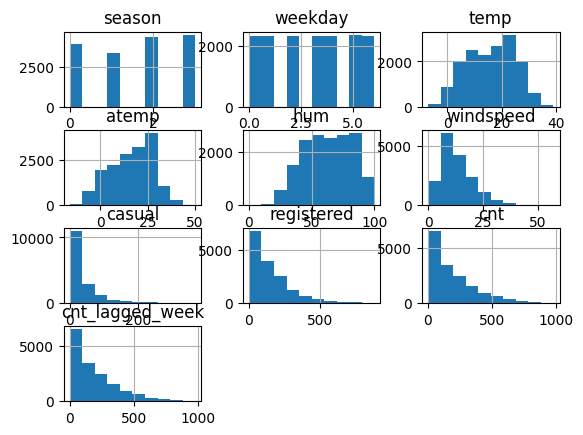

In [11]:
df_train.hist()
plt.show()


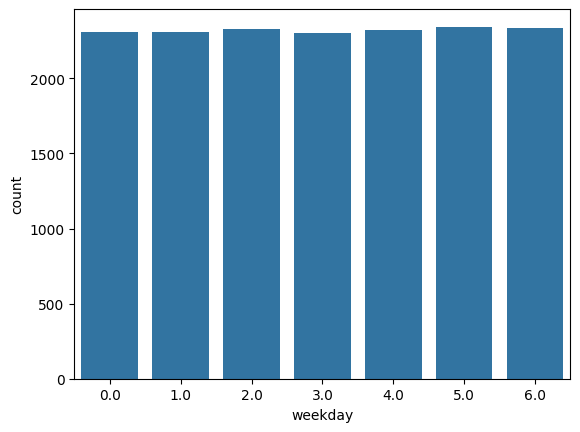

In [12]:
sns.countplot(df_train, x='weekday')
plt.show()

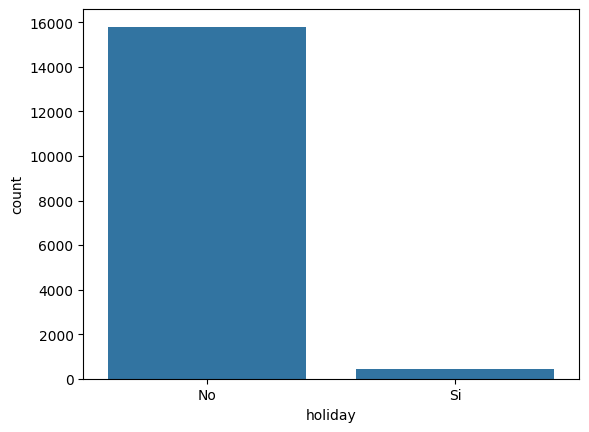

In [13]:
sns.countplot(df_train, x='holiday')
plt.show()

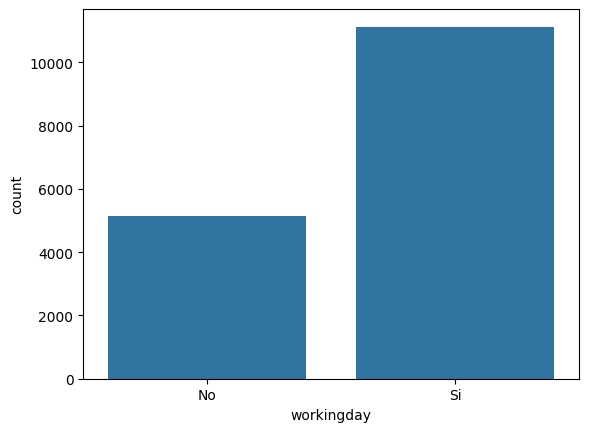

In [14]:
sns.countplot(df_train, x='workingday')
plt.show()

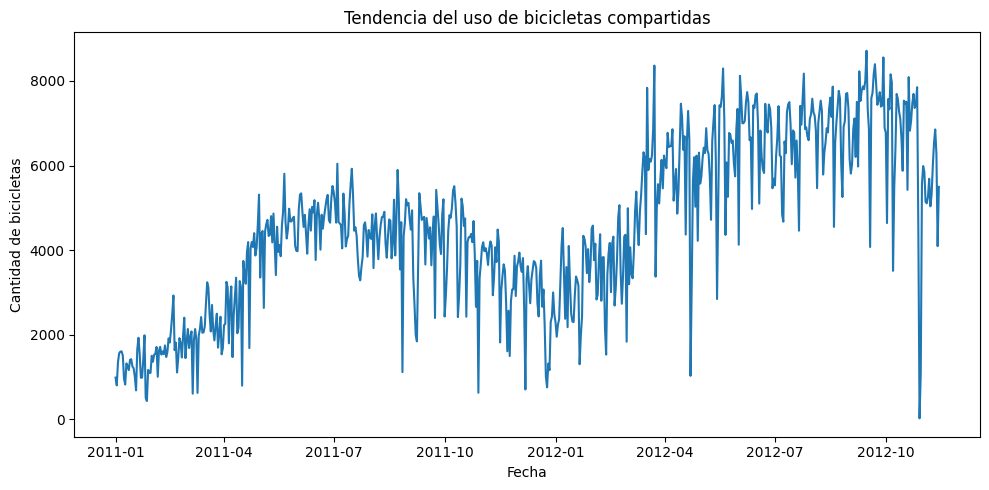

In [16]:
#Creamos una variable "Día" para hacer la línea de tiempo. Hablar con el profesor 
#para decidir si la dejamos o la sacamos
df_daily= df_train['cnt'].resample('D').sum()

plt.figure(figsize=(10,5))
plt.plot(df_daily.index, df_daily.values)
plt.title('Tendencia del uso de bicicletas compartidas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de bicicletas')
plt.tight_layout()
plt.show()

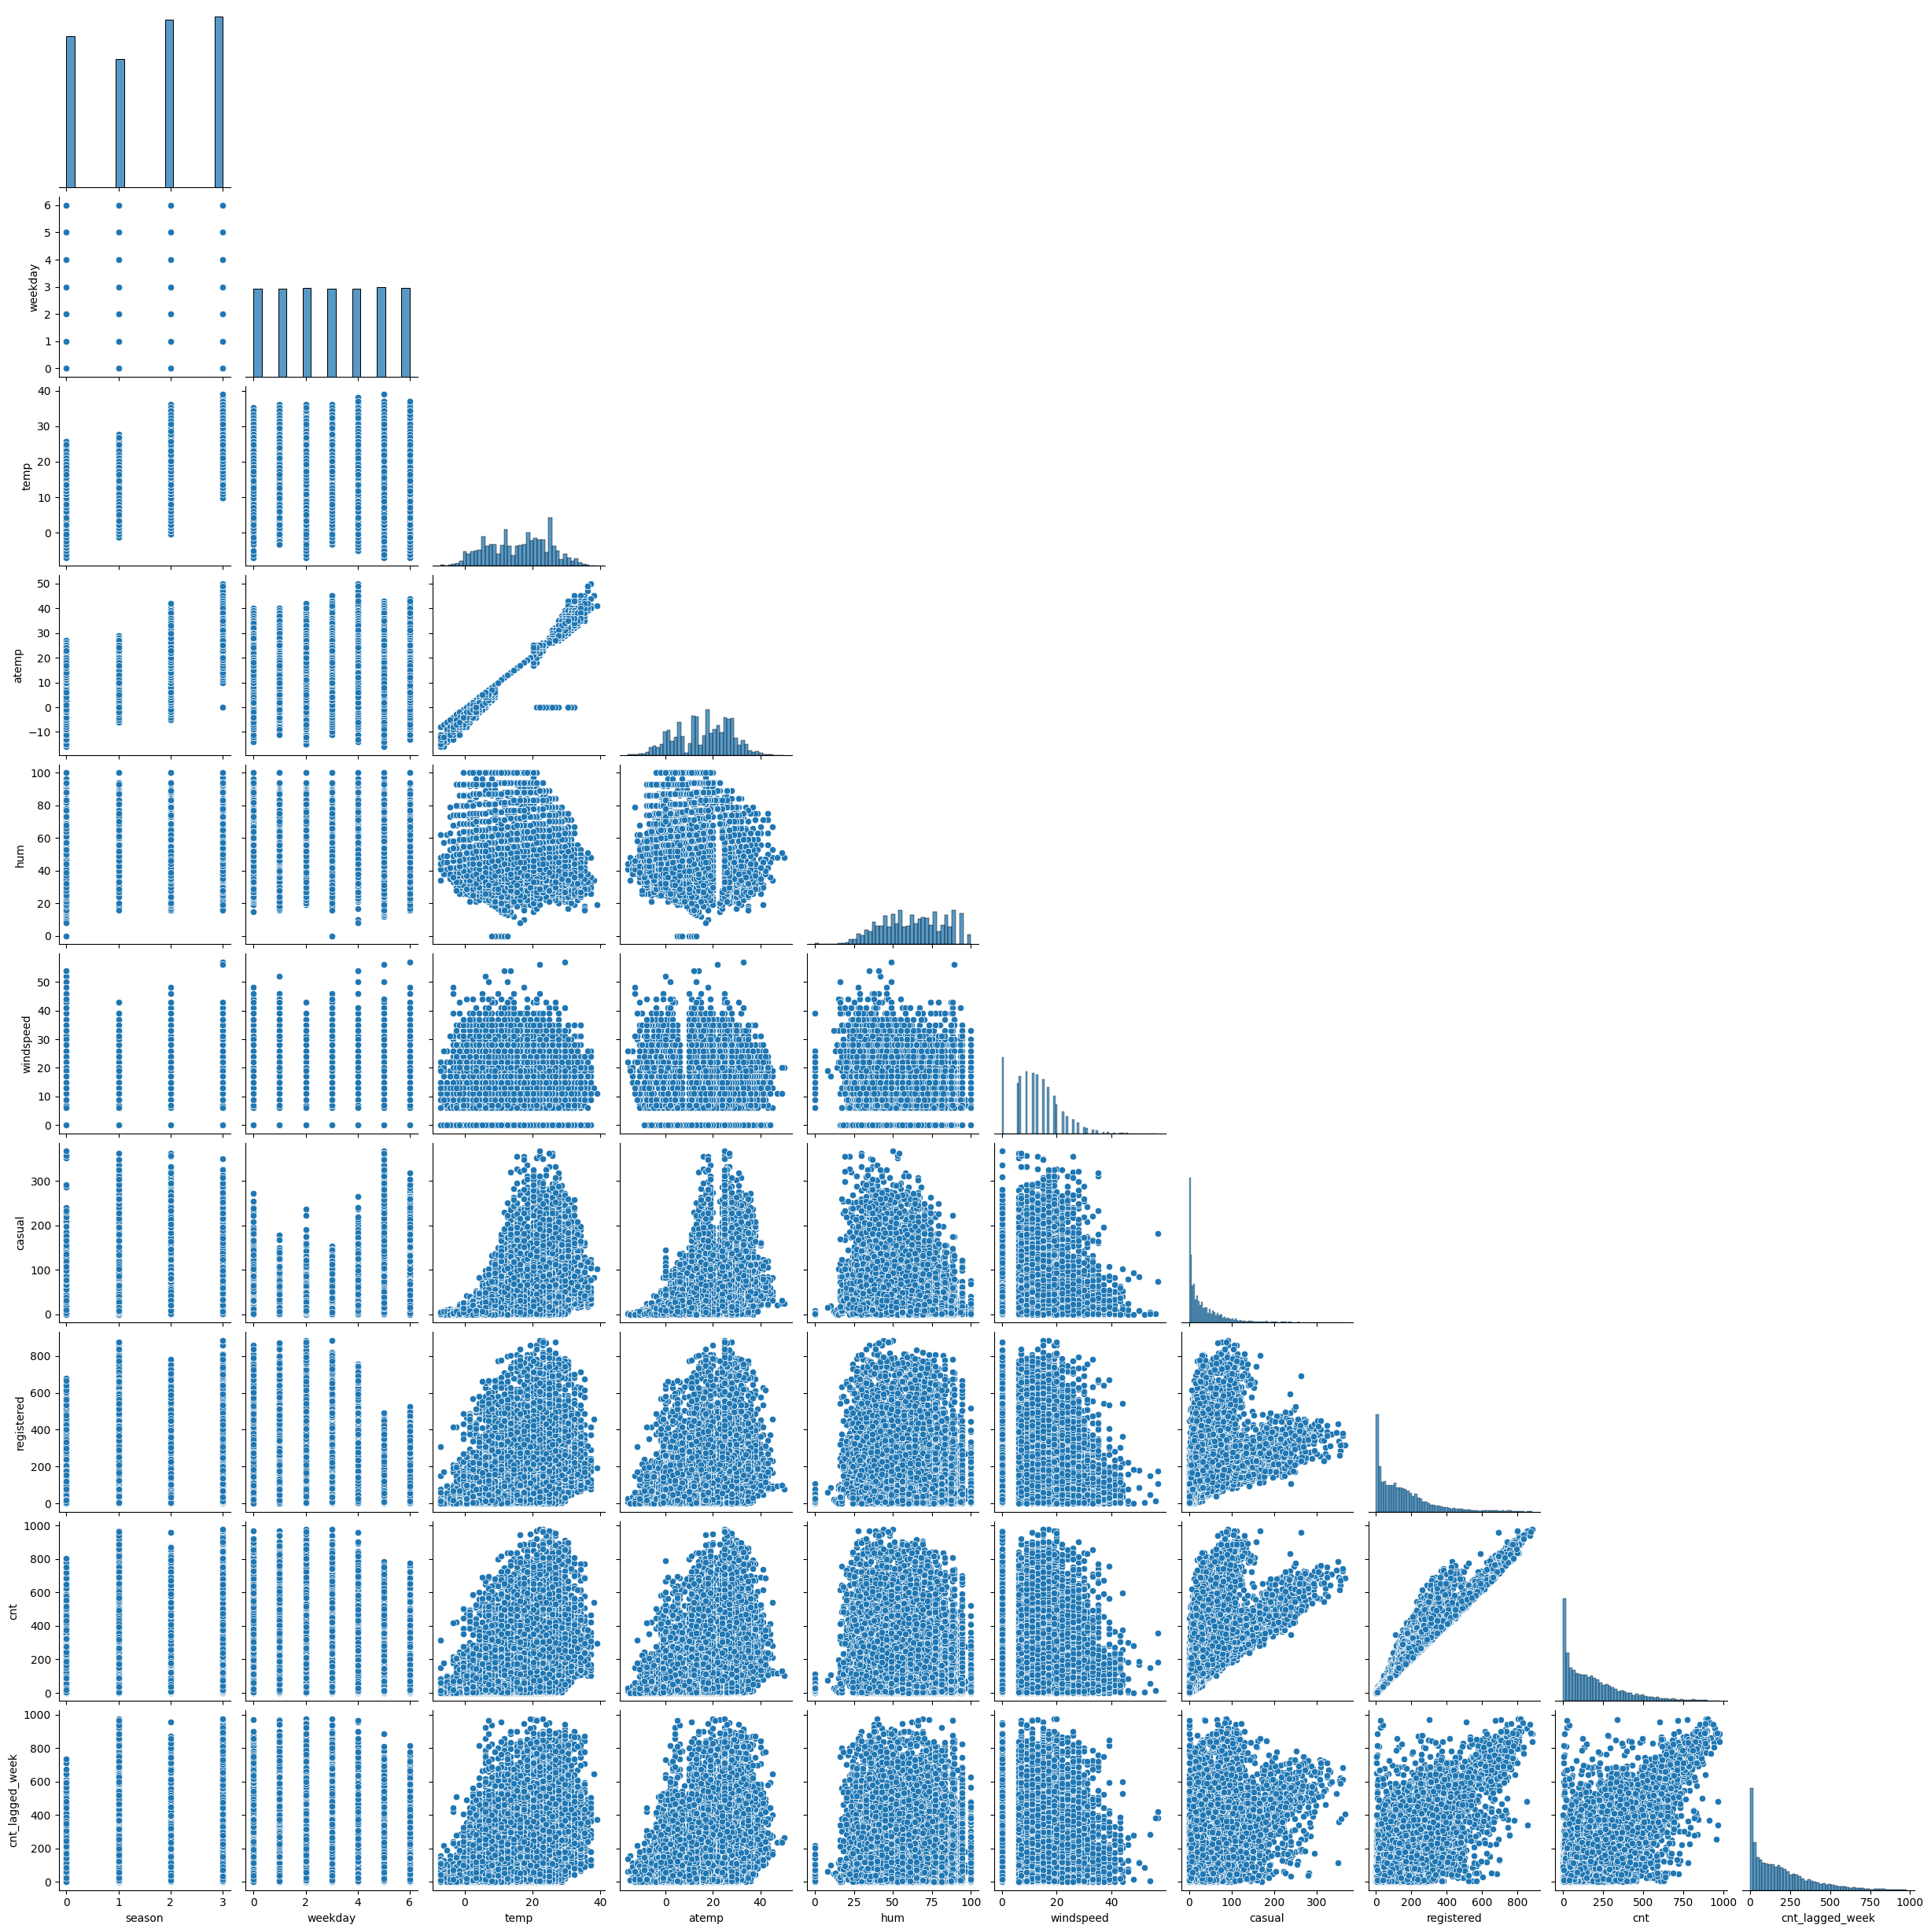

In [17]:
sns.pairplot(df_train, corner=True)
plt.show()

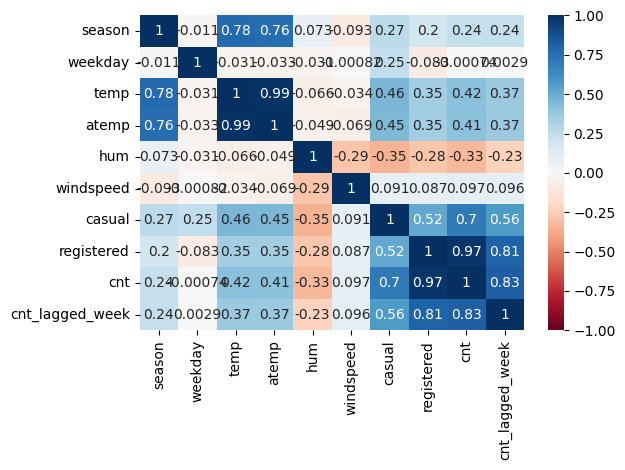

In [39]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.tight_layout()
plt.show()

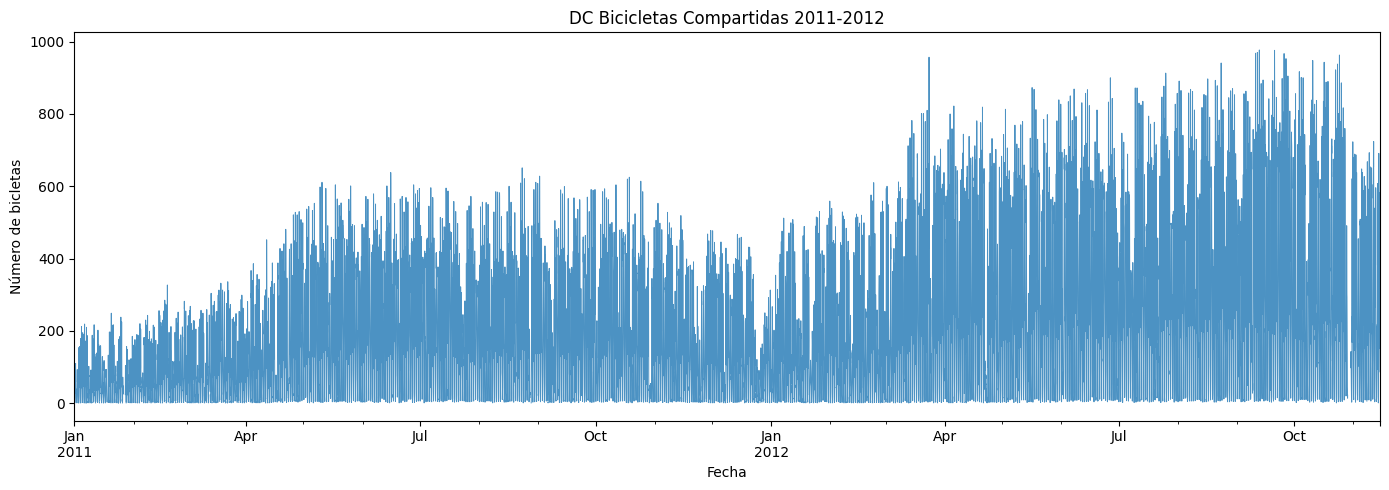

In [18]:
plt.figure(figsize=(14,5))
df_train["cnt"].plot(linewidth=0.7, alpha=0.8)
plt.title("DC Bicicletas Compartidas 2011-2012")
plt.xlabel("Fecha")
plt.ylabel("Número de bicletas")
plt.tight_layout()
plt.show()


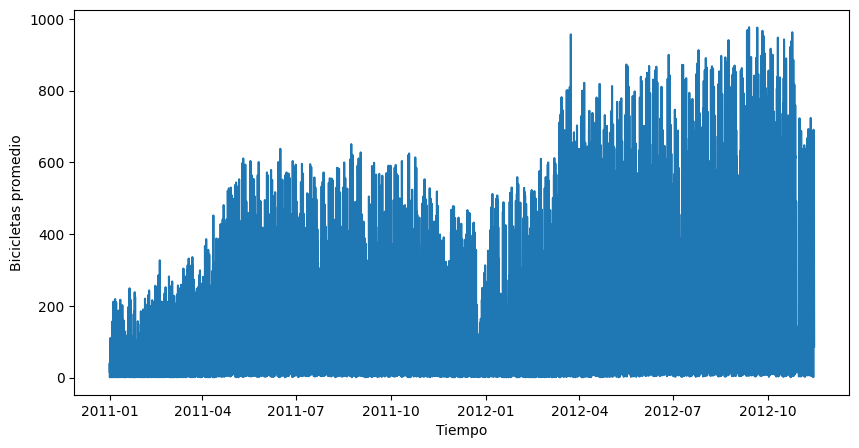

In [19]:
plt.figure(figsize=(10,5))
sns.lineplot(x= "datetime", y="cnt", data= df_train)
plt.xlabel("Tiempo")
plt.ylabel("Bicicletas promedio")
plt.show()

/tmp/ipykernel_10645/2301624307.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  sns.barplot(


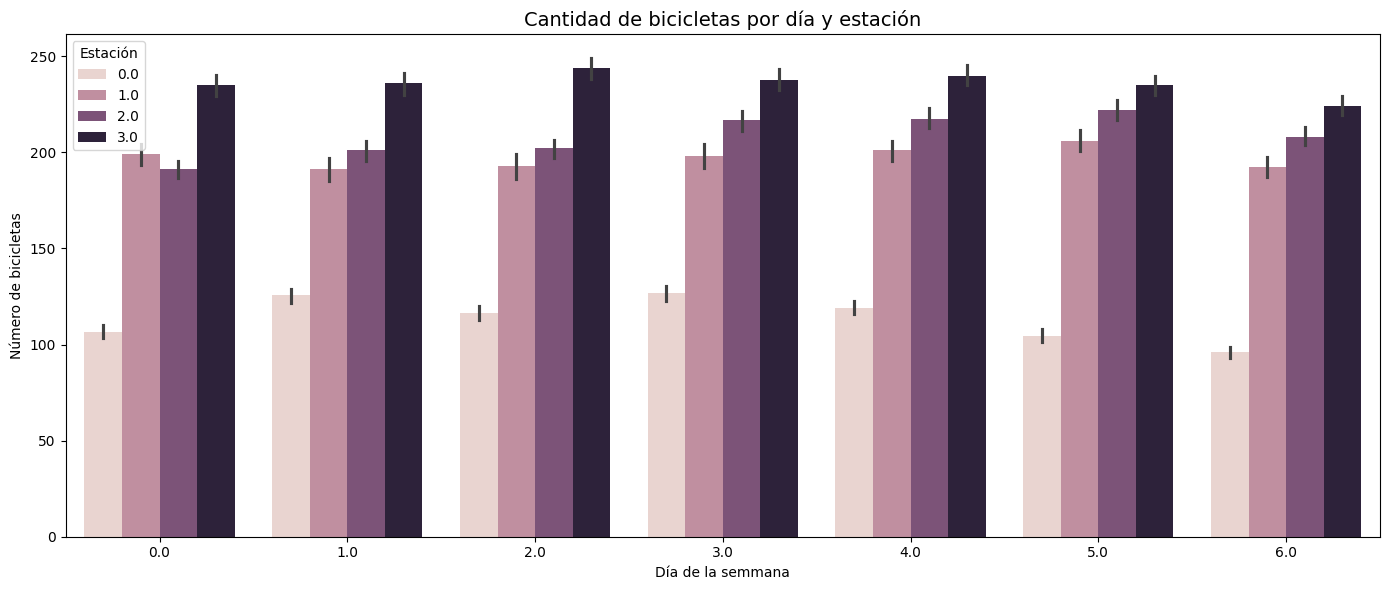

In [20]:
plt.figure(figsize=(14,6))
sns.barplot(
    x="weekday",
    y="cnt",
    hue="season",
    data= df_train,
    ci= 50
)

plt.title("Cantidad de bicicletas por día y estación", fontsize=14)
plt.xlabel("Día de la semmana")
plt.ylabel("Número de bicicletas")
plt.legend(title="Estación")
plt.tight_layout()
plt.show()

/tmp/ipykernel_26891/2545068421.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  sns.barplot(


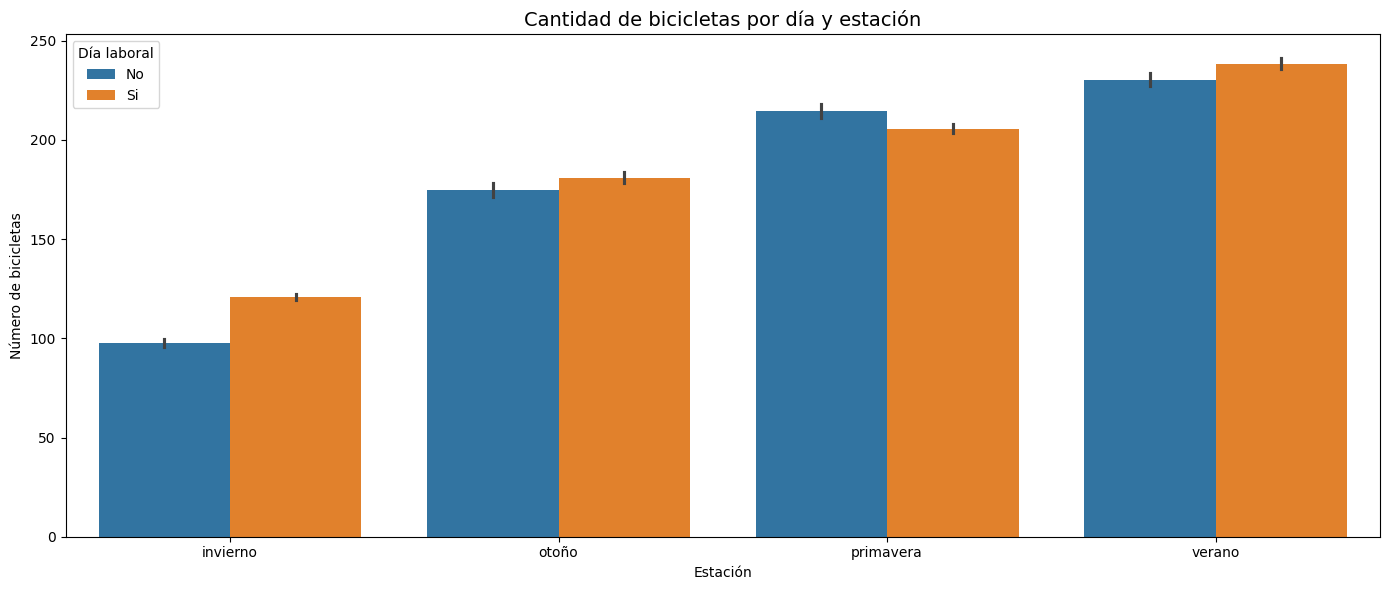

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(
    x="season",
    y="cnt",
    hue="workingday",
    data= df_train,
    ci= 50
)

plt.title("Cantidad de bicicletas por día y estación", fontsize=14)
plt.xlabel("Estación")
plt.ylabel("Número de bicicletas")
plt.legend(title="Día laboral")
plt.tight_layout()
plt.show()

In [31]:
#Machine Learning
target = 'cnt'
X_train = df_train.drop(columns=[target, 'casual', 'registered'])
y_train= df_train[target]
mask_train= y_train.notna()
X_train= X_train[mask_train]
y_train= y_train[mask_train]


X_test= df_test.drop(columns=[target, 'casual', 'registered'])
y_test= df_test[target]
mask_test= y_test.notna()
X_test= X_test[mask_test]
y_test= y_test[mask_test]


In [32]:
num_cols= X_train.select_dtypes('number').columns
cat_cols= X_train.select_dtypes('category').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)

In [33]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
        oob_score= True
    )
    )
])

In [34]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred= pipeline.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 73.46
MSE: 13051.95
RMSE: 114.25
R2: 0.53
